In [1]:
import matplotlib.pyplot as plt
import pandas
import structlog
from astropy import coordinates
from astropy import units as u

from app.lib.storage import postgres


In [ ]:
import os
from dataclasses import dataclass

from experiments import entities, plots


@dataclass
class CrossIDInfo:
    object_id: str
    ra: float
    dec: float
    name: str
    status: entities.CrossIdentificationStatus
    pgc_numbers: list[int]


df = pandas.read_csv("experiments/results/bayes.csv")

df = df[df["status"] == "collision"]
print(df.head())

storage_config = postgres.PgStorageConfig(
    endpoint="dm2.sao.ru", port=5432, dbname="hyperleda", user="hyperleda", password=os.getenv("DB_PASS") or ""
)

rows = df.to_dict(orient="records")

  object_id        ra     dec                 name     status     pgc_numbers
0     obj_0  166.7365 -6.1932  J110656.76-061135.4  collision  125700,1035830
1     obj_1  113.6066 -6.1931  J073425.57-061135.2  collision           77666
2     obj_2  166.3766 -6.1866  J110530.38-061111.6  collision         1035804
3     obj_3  169.0975 -6.1825  J111623.40-061056.9  collision         3264638
5     obj_5  165.5150 -6.1784  J110203.59-061042.3  collision         1035861


2025-07-26 14:41:40 [debug    ] connecting to Postgres         endpoint=dm2.sao.ru port=5432
2025-07-26 14:41:41 [debug    ] SQL query                      args=[[5065992, 1038383, 3264209, 70546, 7544, 1038266, 3260924], [5065992, 1038383, 3264209, 70546, 7544, 1038266, 3260924], 7, 0] query='             WITH              t0 AS (                 SELECT pgc, ra AS "icrs|ra", e_ra AS "icrs|e_ra", dec AS "icrs|dec", e_dec AS "icrs|e_dec"                 FROM layer2.icrs                 WHERE pgc = ANY(%s)             ),              t1 AS (                 SELECT pgc, design AS "designation|design"                 FROM layer2.designation                 WHERE pgc = ANY(%s)             )             SELECT COALESCE(t0.pgc, t1.pgc) AS pgc,                    t0."icrs|ra", t0."icrs|e_ra", t0."icrs|dec", t0."icrs|e_dec", t1."designation|design"             FROM t0 FULL OUTER JOIN t1 USING (pgc)             ORDER BY pgc             LIMIT %s OFFSET %s         '
2025-07-26 14:41:41 [debug    ]

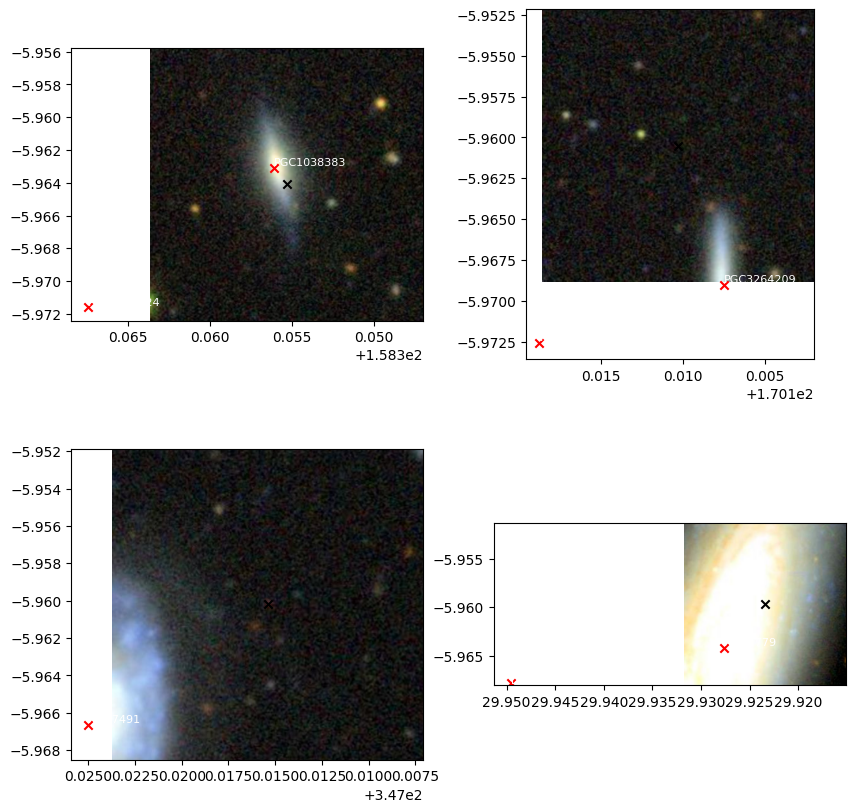

In [5]:
storage = postgres.PgStorage(storage_config, structlog.get_logger())

storage.connect()

offset = 100
grid_rows = 2
grid_cols = 2
num_objects = grid_rows * grid_cols
selected_objs = [CrossIDInfo(**row) for row in rows[offset:num_objects+offset]]

fig, axes_arr = plt.subplots(grid_rows, grid_cols, figsize=(5 * grid_cols, 5 * grid_rows))

fov = 1 / 60
hips_map = 'CDS/P/DESI-Legacy-Surveys/DR10/color'

axes_flat = axes_arr.flatten()

try:
    all_pgc_numbers = set()
    obj_to_pgcs = []
    for obj in selected_objs:
        pgc_numbers = [int(pgc.strip()) for pgc in str(obj.pgc_numbers).split(",") if pgc.strip()]
        obj_to_pgcs.append(pgc_numbers)
        all_pgc_numbers.update(pgc_numbers)

    all_pgc_numbers = list(all_pgc_numbers)
    all_pgc_data = entities.get_pgc_objects_info(all_pgc_numbers, storage)
    pgc_to_obj = {obj.pgc: obj for obj in all_pgc_data}
except Exception as e:
    raise e
finally:
    storage.disconnect()

for obj, ax, pgc_numbers in zip(selected_objs, axes_flat, obj_to_pgcs, strict=False):
   data = [pgc_to_obj[pgc] for pgc in pgc_numbers if pgc in pgc_to_obj]
   collision_data = [(curr_obj.ra, curr_obj.dec, curr_obj.name) for curr_obj in data]
   coords = coordinates.SkyCoord(ra=obj.ra * u.deg, dec=obj.dec * u.deg)
   print(coords)
   print(collision_data)
   plots.get_hips_map(obj.ra, obj.dec, fov, hips_map, collision_data, ax)


# plt.show()